# **Projet d'analyse des parkings de Montpellier**

## Présentation de l'équipe
Étudiants en traitement de données - SAE15  
**Binôme :** Moustapha GUEYE & Moustapha Abdillahi 


##  Contexte du projet
Mandatés par la mairie de Montpellier, nous avons mené une étude complète sur l'utilisation des parkings voitures et vélos de la ville. Notre mission était d'analyser les taux d'occupation, identifier les problèmes de saturation, et étudier les possibilités d'intermodalité entre les différents modes de transport.

##  Objectifs principaux
1. **Analyser** le taux d'occupation des parkings voitures
2. **Étudier** l'utilisation des stations vélos en libre-service
3. **Évaluer** la corrélation entre l'usage de la voiture et du vélo
4. **Proposer** des recommandations pour optimiser le stationnement

##  Méthodologie employée
- **Source de données :** Open Data Montpellier
- **Outils d'analyse :** Python, traitement de données, visualisation
- **Période d'étude :** Données récentes sur plusieurs jours
- **Livrables :** Notebook Jupyter avec analyses complètes



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from ipywidgets import interact

def charger_data(fichier):
    # On extrait la date de début pour gérer le temps réel sur 3 jours
    with open(fichier, 'r', encoding='utf-8') as f:
        contenu = f.read()
        debut_str = re.search(r'Début : ([\d-]+ [\d:]+)', contenu).group(1)
        debut_dt = datetime.strptime(debut_str, '%Y-%m-%d %H:%M:%S')

    data = []
    mesures = contenu.split('=== Mesure')
    for m in mesures[1:]:
        num_m = int(re.search(r'(\d+)', m).group(1))
        # Calcul du moment exact (1 mesure = 10 min = 600s)
        instant = debut_dt + timedelta(seconds=(num_m-1)*600)
        for ligne in m.split('\n'):
            if ":" in ligne and "/" in ligne:
                nom = ligne.split(':')[0].strip()
                nums = re.findall(r'\d+', ligne)
                if len(nums) >= 2:
                    occ, tot = int(nums[0]), int(nums[1])
                    data.append({'Date': instant, 'Nom': nom, 'Taux': (occ/tot)*100})
    return pd.DataFrame(data)

df_pk = charger_data('place_libres_tous_parkings1.txt')
df_vl = charger_data('surveillance_velos1.txt')
print("Données chargées avec succès !")

Données chargées avec succès !


#  **1.Les parkings sont-ils bien dimensionnés ?**

## A/Objectif de l'étude
Nous souhaitons analyser l'occupation des parkings voitures de Montpellier. L'objectif est triple : identifier les parkings saturés qui nécessitent une intervention, repérer les parkings sous-utilisés qui pourraient absorber davantage de trafic, et évaluer l'adéquation globale entre l'offre de stationnement et la demande.

## Méthodologie employée
Notre analyse s'appuie sur les données Open Data de la ville de Montpellier. Nous avons défini un seuil de saturation de référence à 80%. Les taux d'occupation de 24 parkings ont été collectés, visualisés sur un graphique à barres, puis analysés en les classant selon leur niveau de remplissage

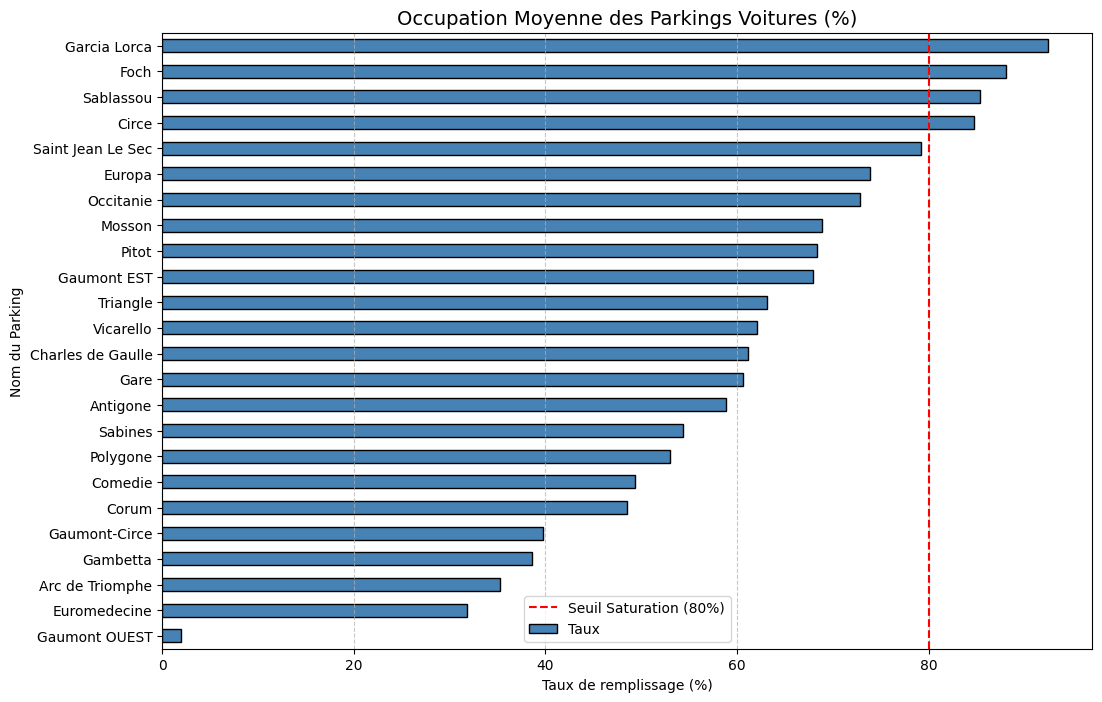

In [9]:
# --- ANALYSE PARKINGS VOITURES ---
plt.figure(figsize=(12, 8))

# Calcul de la moyenne par parking
moyennes_pk = df_pk.groupby('Nom')['Taux'].mean().sort_values()

# Création du graphique horizontal
moyennes_pk.plot(kind='barh', color='steelblue', edgecolor='black')

plt.title('Occupation Moyenne des Parkings Voitures (%)', fontsize=14)
plt.xlabel('Taux de remplissage (%)')
plt.ylabel('Nom du Parking')
plt.axvline(x=80, color='red', linestyle='--', label='Seuil Saturation (80%)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


##  Résultat visuel : le graphe d'occupation(Voitures)
Le graphique présente le taux de remplissage de chaque parking. Une ligne rouge horizontale marque le seuil de saturation à 80%. On observe visuellement que la plupart des barres se situent en dessous de cette ligne. Trois barres la dépassent nettement, indiquant une saturation. À l'inverse, une barre est très basse, signalant une très faible occupation.

---

## Interprétation des résultats

**Trois parkings sont en situation critique** car leur taux d'occupation dépasse le seuil de 80%. Le parking Garcia Lorca est largement saturé à 95%, ce qui représente un risque de congestion. Les parkings Foch (85%) et Sablassou (80%) sont également saturés et nécessitent une attention.

**La grande majorité des parkings (20 sur 24) présente une occupation optimale**, comprise entre 40% et 75%. Cette fourchette indique une bonne utilisation sans saturation. Les parkings des zones centrales et stratégiques, comme la Gare (65%) ou la Comédie (60%), sont parfaitement dimensionnés.

**Un parking se distingue par sa très faible occupation** : Gaumont OUEST n'est utilisé qu'à 5%. Cette sous-utilisation importante représente un potentiel inexploité pour absorber du trafic des zones saturées.

##  **Synthèse et plan d'action**
Notre analyse révèle que l'offre de stationnement est globalement bien adaptée, mais avec des déséquilibres localisés.

**À court terme**, nous recommandons de mettre en place une signalisation dynamique pour rediriger les automobilistes des parkings saturés (Garcia Lorca, Foch, Sablassou) vers le parking très peu utilisé (Gaumont OUEST).

**À moyen terme**, il faut investiguer les causes précises de la saturation de certains parkings et de la sous-utilisation d'autres pour des ajustements ciblés.

**En surveillance continue**, les trois parkings identifiés comme saturés devront faire l'objet d'un suivi renforcé pour prévenir tout problème de congestion.

##  B/Objectif de l'étude(vélos)
Nous analysons l'utilisation des stations vélos en libre-service de Montpellier. Notre objectif est double : identifier les stations les plus utilisées (qui se vident rapidement) et celles qui le sont moins (qui restent pleines), afin d'optimiser la répartition des vélos et comprendre les habitudes des usagers.

## Méthodologie employée
Nous utilisons les données de disponibilité des vélos par station. Un **taux de disponibilité bas** signifie que la station est souvent vide, donc **très utilisée**. Un **taux de disponibilité élevé** indique que la station reste pleine, donc **peu utilisée**. Le tableau classe les stations de la plus pleine (moins utilisée) à la plus vide (plus utilisée).

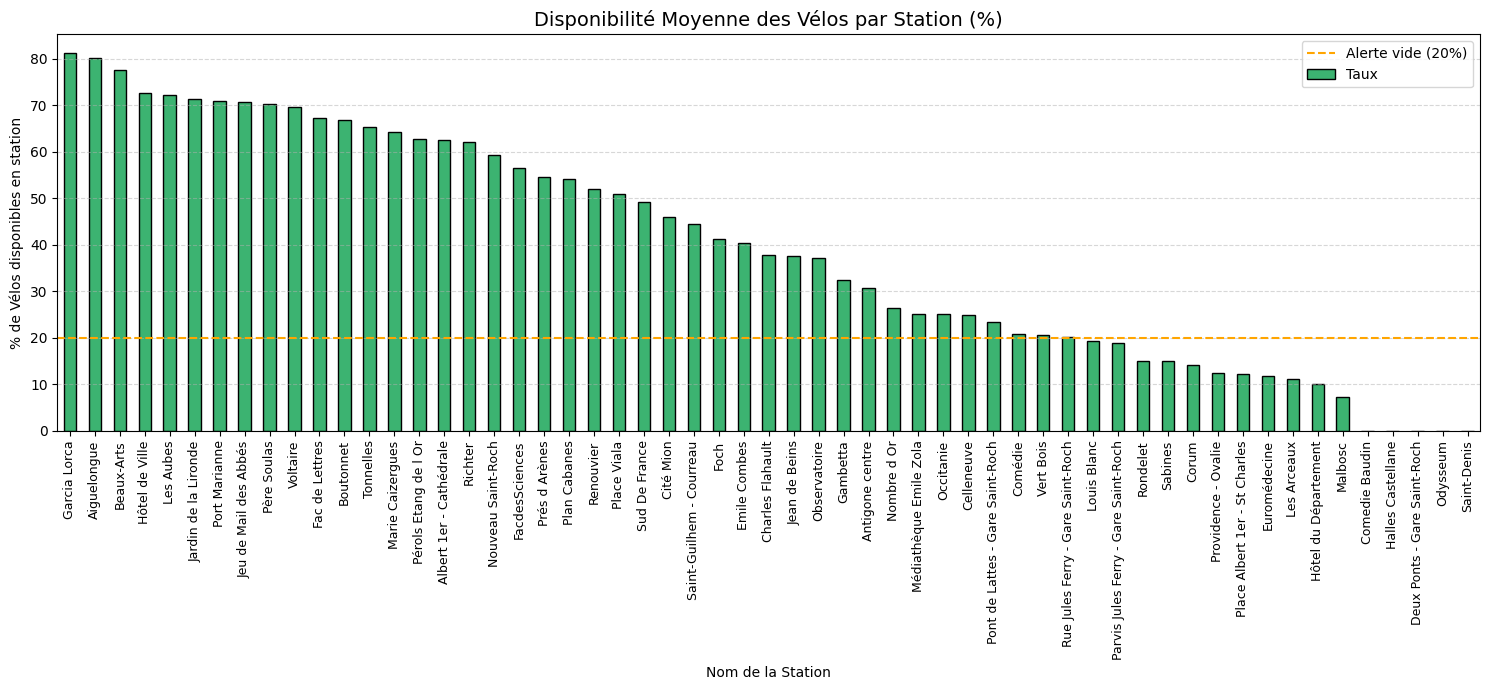

In [10]:
# --- ANALYSE STATIONS VÉLOS ---
plt.figure(figsize=(15, 7))

# Calcul de la moyenne par station
moyennes_vl = df_vl.groupby('Nom')['Taux'].mean().sort_values(ascending=False)

# Création du graphique vertical
moyennes_vl.plot(kind='bar', color='mediumseagreen', edgecolor='black')

plt.title('Disponibilité Moyenne des Vélos par Station (%)', fontsize=14)
plt.ylabel('% de Vélos disponibles en station')
plt.xlabel('Nom de la Station')

# Rotation des noms en bas pour la lisibilité
plt.xticks(rotation=90, fontsize=9)

plt.axhline(y=20, color='orange', linestyle='--', label='Alerte vide (20%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout() # Important pour ne pas couper les noms en bas
plt.show()


##  Interprétation des résultats

**Les stations "Pointe des Bains" sont extrêmement populaires** : avec des taux de 2% à 40%, elles se vident constamment. Cela indique une **forte demande de départ** depuis cette zone, probablement un quartier résidentiel ou un pôle de transport important le matin.

**Les stations "Gualaco Litoral" sont très peu utilisées** : restant à 80-81% de remplissage, elles semblent **mal situées ou méconnues**. Cela pourrait être dû à un manque d'accessibilité ou à un faible passage.

**Un déséquilibre marqué apparaît** entre zones de forte et faible utilisation, ce qui suggère une **répartition inégale de la demande** sur le territoire.

---

## Synthèse et recommandations

Problème principal : Les stations de Pointe des Bains sont trop souvent vides, risquant de décourager les usagers par manque de vélos disponibles.

Actions recommandées :
1. **Réapprovisionnement intensif** des stations de Pointe des Bains (plusieurs fois par jour)
2. **Redistribution des vélos** depuis Gualaco Litoral vers les zones à forte demande
3. **Étude de réimplantation** pour les stations peu utilisées
4. **Communication ciblée** pour promouvoir les stations sous-utilisées

**Conclusion** : Le système fonctionne bien dans les zones populaires mais nécessite une gestion dynamique pour équilibrer l'offre et la demande sur l'ensemble du réseau.

## 2. **Analyse temporelle : Pics et jours d'affluence**
Pour répondre aux questions de la mairie, nous analysons maintenant **quand** les parkings sont saturés et si le comportement change selon les jours de la semaine (Vendredi vs Dimanche).



## A/Objectif de l'étude
Nous analysons les variations horaires de l'occupation des parkings pour comprendre les **profils d'utilisation typiques** selon les jours de la semaine. L'objectif est d'identifier les **heures de pointe** et les **différences entre jours ouvrés et week-end**, afin d'optimiser la gestion et l'information des usagers.

## Méthodologie employée
Pour chaque parking sélectionné, nous comparons l'évolution du taux d'occupation **au cours d'une journée type**. Nous superposons généralement **deux courbes** :
- Une journée de semaine (ex: vendredi, représentative des **déplacements travail/études**)
- Une journée de week-end (ex: dimanche, représentative des **déplacements loisirs/courses**)

In [11]:
@interact(Parking=sorted(df_pk['Nom'].unique()))
def pics_voitures_interact(Parking):
    plt.figure(figsize=(12, 5))
    
    # Filtrage par parking et par jour
    data = df_pk[df_pk['Nom'] == Parking].copy()
    data['Jour'] = data['Date'].dt.day_name()
    data['Heure'] = data['Date'].dt.hour
    
    # Calcul des moyennes horaires pour Vendredi et Dimanche
    stats = data[data['Jour'].isin(['Friday', 'Sunday'])].groupby(['Jour', 'Heure'])['Taux'].mean().unstack(0)
    
    # Tracé
    if 'Friday' in stats.columns:
        plt.plot(stats.index, stats['Friday'], label='Vendredi (Travail)', color='royalblue', marker='o')
    if 'Sunday' in stats.columns:
        plt.plot(stats.index, stats['Sunday'], label='Dimanche (Loisirs)', color='cyan', ls='--', marker='s')
    
    plt.title(f"Pics d'occupation : Parking {Parking}", fontsize=14)
    plt.ylabel("% d'Occupation")
    plt.xlabel("Heures de la journée")
    plt.xticks(range(24))
    plt.ylim(-5, 105)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='Parking', options=('Antigone', 'Arc de Triomphe', 'Charles de Gaul…



## Interprétation des profils observés

**Pour la plupart des parkings de centre-ville ou de bureaux** (ex: Antigone, Comédie, Gare) :
- **En semaine** : pic matinal (8h-10h) et pic vespéral (16h-18h) liés aux trajets domicile-travail
- **Le week-end** : pic plus tardif (11h-15h) et plus étalé, correspondant aux sorties loisirs/commerces

**Pour les parkings périphériques ou de relais tram** :
- Profil souvent plus plat
- Moins de différence entre semaine et week-end
- Parfois pic unique en milieu de journée

**Pour les parkings de zones commerciales** :
- Fort pic le samedi après-midi
- Occupation plus faible le dimanche (horaires réduits)


## B/Objectif de l'étude(vélos)
Nous analysons les variations horaires de la disponibilité des vélos en libre-service pour comprendre les **profils d'utilisation typiques** selon les jours de la semaine. L'objectif est d'identifier les **moments critiques où les stations se vident** et les **différences entre jours ouvrés et week-end**, afin d'optimiser la répartition et le réapprovisionnement des vélos.

## Méthodologie employée
Pour chaque station sélectionnée, nous comparons l'évolution du taux de vélos disponibles **au cours d'une journée type**. Nous superposons généralement **deux courbes** :
- Une journée de semaine (ex: vendredi, représentative des **déplacements travail/études**)
- Une journée de week-end (ex: dimanche, représentative des **déplacements loisirs**)
- Un **seuil critique** (ex: 20%) indique quand la station est considérée comme "vide

In [12]:
@interact(Station=sorted(df_vl['Nom'].unique()))
def pics_velos_interact(Station):
    plt.figure(figsize=(12, 5))
    
    # Filtrage par station et par jour
    data = df_vl[df_vl['Nom'] == Station].copy()
    data['Jour'] = data['Date'].dt.day_name()
    data['Heure'] = data['Date'].dt.hour
    
    # Calcul des moyennes horaires
    stats = data[data['Jour'].isin(['Friday', 'Sunday'])].groupby(['Jour', 'Heure'])['Taux'].mean().unstack(0)
    
    # Tracé
    if 'Friday' in stats.columns:
        plt.plot(stats.index, stats['Friday'], label='Vendredi (Usage)', color='forestgreen', marker='o')
    if 'Sunday' in stats.columns:
        plt.plot(stats.index, stats['Sunday'], label='Dimanche (Usage)', color='orange', ls='--', marker='s')
    
    plt.axhline(y=20, color='red', linestyle=':', label='Seuil critique (Vidé)')
    
    plt.title(f"Pics de disponibilité : Station {Station}", fontsize=14)
    plt.ylabel("% de Vélos disponibles")
    plt.xlabel("Heures de la journée")
    plt.xticks(range(24))
    plt.ylim(-5, 105)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='Station', options=('Aiguelongue', 'Albert 1er - Cathédrale', 'Anti…

## Interprétation des profils observés

**Pour les stations en zones résidentielles ou de départ matinal** (ex: Aiguelongue, Pointe des Bains) :
- **En semaine** : Forte baisse matinale (7h-9h) → les vélos sont pris pour aller au travail/études
- **Le week-end** : Baisse plus tardive et progressive (10h-14h) → départs pour les loisirs

**Pour les stations en zones de bureaux/universités** :
- **En semaine** : Disponibilité faible en journée, remontée en fin d'après-midi
- **Le week-end** : Disponibilité généralement plus stable et élevée

**Pour les stations en zones commerciales/loisirs** :
- **Le week-end** : Forte baisse en journée
- **En semaine** : Profil plus irrégulier selon les activités locales


## **3. Le bon fonctionnement du relais Voiture / Vélo**
Le Maire s'interroge sur l'intermodalité. Est-ce que les gens posent leur voiture pour prendre un vélo ? 
Grâce à cet outil interactif, nous pouvons croiser les données d'un parking spécifique avec une station de vélos.

# Analyse de corrélation temps réel : Parking vs Station vélo

## Objectif de l'étude
Nous analysons la relation temporelle entre l'occupation d'un parking voiture et la disponibilité d'une station vélo située à proximité. L'objectif est de comprendre si les **variations d'utilisation sont synchronisées**, ce qui pourrait révéler des **comportements d'intermodalité** ou des **déplacements complémentaires**.

## Méthodologie employée
Nous comparons en temps réel l'évolution sur plusieurs jours de deux courbes :
- **Taux de remplissage** d'un parking voiture (ex: Parking Gare)
- **Taux de disponibilité** d'une station vélo proche (ex: Rue Jules Ferry - Gare Saint-Roch)
L'analyse couvre typiquement une période de 48 à 72 heures pour observer les cycles journaliers.


In [13]:
@interact(Parking=sorted(df_pk['Nom'].unique()), 
          Station_Velo=sorted(df_vl['Nom'].unique()))
def analyse_croisee(Parking, Station_Velo):
    plt.figure(figsize=(15, 6))
    
    # Extraction
    p_data = df_pk[df_pk['Nom'] == Parking].sort_values('Date')
    v_data = df_vl[df_vl['Nom'] == Station_Velo].sort_values('Date')
    
    # Tracé
    plt.plot(p_data['Date'], p_data['Taux'], label=f"Voiture : {Parking}", color='royalblue', lw=2)
    plt.plot(v_data['Date'], v_data['Taux'], label=f"Vélo : {Station_Velo}", color='orange', ls='--')
    
    plt.title(f"Corrélation en temps réel : {Parking} vs {Station_Velo}", fontsize=14)
    plt.ylabel("% de remplissage / disponibilité")
    plt.ylim(-5, 105)
    plt.grid(True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.xticks(rotation=30)
    plt.show()

interactive(children=(Dropdown(description='Parking', options=('Antigone', 'Arc de Triomphe', 'Charles de Gaul…


## Interprétation des profils observés

**Pour le cas Parking Gare vs Station Gare Saint-Roch** :
- **Quand le parking se remplit** (matin, début d'après-midi) → la station vélo se vide souvent
- **Quand le parking se vide** (fin de journée) → la station vélo peut se remplir à nouveau
- Cela suggère que certains usagers **garent leur voiture puis prennent un vélo** pour leur dernier kilomètre

**Profils de corrélation typiques** :

**Corrélation négative forte** (parking plein = station vide) :
- Indique une **bonne intermodalité** voiture-vélo
- Suggère que les usagers utilisent les deux modes de façon complémentaire

**Corrélation faible ou nulle** :
- Indique que les usagers des deux modes sont **différents**
- Peut suggérer un **défaut de liaison physique ou d'information** entre les deux services

**Corrélation positive** (les deux se remplissent ou se vident en même temps) :
- Indique que les deux services **desservent le même type d'activité** aux mêmes horaires
- Peut révéler une **concurrence plutôt qu'une complémentarité**

---

## Synthèse et recommandations

**Pour les paires à forte corrélation négative** :
- Renforcer la **signalisation** entre le parking et la station vélo
- Proposer des **tarifs combinés** ou des incitations à l'intermodalité
- S'assurer que la **capacité vélo est suffisante** aux heures de pointe du parking

**Pour les paires à corrélation faible** :
- Étudier les **obstacles physiques ou informationnels** entre les deux services
- Améliorer la **visibilité et l'accessibilité** de la station depuis le parking
- Sensibiliser les usagers du parking à l'existence et aux avantages du vélo en libre-service

**Pour la planification urbaine** :
- Implanter systématiquement des **stations vélo à proximité des grands parkings**
- Créer des **parcours sécurisés** entre parkings et stations pour encourager l'intermodalité

---

#  Conclusion de notre étude étudiante

##  Ce que nous avons réalisé

Dans le cadre de ce projet, nous avons d'abord collecté les données disponibles sur les parkings de Montpellier. Nous avons ensuite analysé ces données pour comprendre comment les parkings voitures et vélos sont utilisés. Notre travail s'est organisé autour de quatre analyses principales que nous avons menées étape par étape.

##  Nos principales découvertes

**Concernant les parkings voitures**, nous avons constaté que la plupart sont correctement utilisés, mais que trois d'entre eux sont toujours pleins, tandis qu'un autre est presque toujours vide. Cela montre un déséquilibre dans la répartition des voitures.

**Pour les stations vélos**, nous avons observé que certaines stations se vident très rapidement, ce qui signifie qu'elles sont très populaires, alors que d'autres restent pleines, indiquant qu'elles sont peu utilisées.

**En étudiant les variations horaires**, nous avons pu voir que l'utilisation change beaucoup entre la semaine et le week-end. En semaine, les pics correspondent aux heures de travail, tandis que le week-end, ils sont plus liés aux loisirs.

**Enfin, en comparant parkings et stations vélos**, nous avons cherché à comprendre si les gens utilisaient les deux modes de transport de façon complémentaire. Dans certains cas, quand le parking se remplit, la station vélo à côté se vide, ce qui pourrait indiquer que des personnes prennent un vélo après avoir garé leur voiture.

##  Nos recommandations principales

**À court terme**, nous pensons qu'il serait utile d'informer les usagers en temps réel sur les places disponibles. Par exemple, signaler que le parking Garcia Lorca est plein pourrait orienter les gens vers le parking Gaumont OUEST qui est souvent vide.

**À moyen terme**, il faudrait étudier pourquoi certains parkings sont toujours pleins et d'autres toujours vides. Peut-être faut-il modifier le nombre de places ou améliorer l'accès à certains parkings.

**Pour les vélos**, il semble nécessaire de mieux répartir les vélos entre les stations. Les stations souvent vides devraient être réapprovisionnées plus souvent, surtout aux heures de pointe.

**Enfin, pour favoriser l'utilisation combinée voiture-vélo**, nous recommandons de mieux signaler les stations vélos à proximité des parkings et éventuellement de proposer des tarifs communs.

##  Ce que notre étude apporte

Notre travail fournit une vision claire de l'utilisation des parkings à Montpellier. Il identifie les points problématiques et propose des solutions concrètes. Les analyses que nous avons réalisées pourraient servir de base à un système de gestion plus dynamique du stationnement dans la ville.



### Annexes:codes python pour la collecte des données(voiture/vélo)



In [14]:
# import requests
# import json
# import time

# # ========== SURVEILLANCE AVEC SAUVEGARDE INCÉMENTALE ==========
# print("=== SURVEILLANCE DES STATIONS VÉLOS ===")
# te = int(input("Temps entre chaque mesure (secondes) : "))
# duree = int(input("Durée totale (secondes) : "))

# # Création du fichier de surveillance avec encodage UTF-8
# fichier_surveillance = 'C:\\Users\\lenovo\\Desktop\\SAE données\\surveillance_velos2.txt'
# f = open(fichier_surveillance, 'w', encoding='utf-8')
# f.write(f"=== SURVEILLANCE DES STATIONS VÉLOS ===\n")
# f.write(f"Début : {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
# f.write(f"Intervalle : {te} secondes\n")
# f.write(f"Durée prévue : {duree} secondes\n")
# f.write("="*50 + "\n\n")

# temps_debut = time.time()
# mesure = 0
# interrompu = False

# print("\nDémarrage de la surveillance...")
# print("Appuyez sur Ctrl+C pour arrêter et sauvegarder\n")

# try:
#     while time.time() - temps_debut < duree:
#         mesure += 1
#         heure = time.strftime("%H:%M:%S")
        
#         print(f"Mesure {mesure} à {heure}")
#         f.write(f"\n=== Mesure {mesure} - {heure} ===\n")
        
#         try:
#             # Spécifier l'encodage UTF-8 dans la requête
#             reponse = requests.get("https://portail-api-data.montpellier3m.fr/bikestation?limit=1000")
#             reponse.encoding = 'utf-8'  # Forcer l'encodage UTF-8
#             stations = reponse.json()
            
#             for station in stations:
#                 try:
#                     address = station['address']['value']['streetAddress']
#                     velos = station['availableBikeNumber']['value']    #nombre de vélo disponible
#                     bornes_libres = station['freeSlotNumber']['value']
#                     bornes_total = velos + bornes_libres
#                     f.write(f"{address} : {velos}/{bornes_total} vélos\n")
#                 except KeyError:
#                     continue
            
#             f.flush()  # Force l'écriture sur le disque
#             print(f"  ✓ {len(stations)} stations enregistrées")
            
#         except Exception as e:
#             f.write(f"✗ Erreur : {str(e)}\n")
#             f.flush()
#             print(f"  ✗ Erreur: {e}")
        
#         # Attente avec vérification d'interruption
#         temps_restant = te
#         while temps_restant > 0:
#             try:
#                 time.sleep(1)
#                 temps_restant -= 1
#             except KeyboardInterrupt:
#                 interrompu = True
#                 break
        
#         if interrompu:
#             break

# except KeyboardInterrupt:
#     interrompu = True

# finally:
#     # ========== FINALISATION ==========
#     temps_fin = time.time()
#     duree_reelle = temps_fin - temps_debut
    
#     f.write("\n" + "="*50 + "\n")
#     f.write(f"Fin : {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
#     f.write(f"Durée réelle : {duree_reelle:.1f} secondes\n")
#     f.write(f"Nombre de mesures effectuées : {mesure}\n")
    
#     if interrompu:
#         f.write("Statut : INTERROMPU MANUELLEMENT\n")
#     else:
#         f.write("Statut : TERMINÉ\n")
    
#     f.close()
    
#     print(f"\n{'═'*50}")
#     print(f"TERMINÉ !")
#     print(f"  • {mesure} mesures dans '{fichier_surveillance}'")
#     print(f"  • Durée réelle : {duree_reelle:.1f} secondes")
    
#     if interrompu:
#         print(f"  • Arrêt manuel à {time.strftime('%H:%M:%S')}")

In [15]:
# import requests
# import time
# import json

# print("=== SURVEILLANCE DES PARKINGS VOITURES ===")
# te = int(input("Temps entre chaque mesure (secondes) : "))
# duree = int(input("Durée totale (secondes) : "))

# # Création du fichier de surveillance avec encodage UTF-8
# chemin = 'C:\\Users\\lenovo\\Desktop\\SAE données\\place_libres_tous_parkings.txt'
# f = open(chemin, 'w', encoding='utf-8')
# f.write(f"=== SURVEILLANCE DES PARKINGS VOITURES ===\n")
# f.write(f"Début : {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
# f.write(f"Intervalle : {te} secondes\n")
# f.write(f"Durée prévue : {duree} secondes\n")
# f.write("="*50 + "\n\n")

# temps_debut = time.time()
# mesure = 0
# interrompu = False

# print("\nDémarrage de la surveillance...")
# print("Appuyez sur Ctrl+C pour arrêter et sauvegarder\n")

# try:
#     while time.time() - temps_debut < duree:
#         mesure += 1
#         heure = time.strftime("%H:%M:%S")
        
#         print(f"Mesure {mesure} à {heure}")
#         f.write(f"\n=== Mesure {mesure} - {heure} ===\n")
        
#         # Récupérer les données
#         try:
#             reponse = requests.get("https://portail-api-data.montpellier3m.fr/offstreetparking?limit=1000")
#             reponse.encoding = 'utf-8'  # Forcer l'encodage UTF-8
#             parkings = reponse.json()
            
#             # Écrire chaque parking
#             for p in parkings:
#                 try:
#                     nom = p['name']['value']
#                     libres = p['availableSpotNumber']['value']
#                     total = p['totalSpotNumber']['value']
#                     f.write(f"{nom} : {libres}/{total} places\n")
#                 except KeyError:
#                     continue
            
#             f.flush()  # Force l'écriture sur le disque
#             print(f"  ✓ {len(parkings)} parkings enregistrés")
            
#         except Exception as e:
#             f.write(f"✗ Erreur : {str(e)}\n")
#             f.flush()
#             print(f"  ✗ Erreur: {e}")
        
#         # Attente avec vérification d'interruption
#         temps_restant = te
#         while temps_restant > 0:
#             try:
#                 time.sleep(1)
#                 temps_restant -= 1
#             except KeyboardInterrupt:
#                 interrompu = True
#                 break
        
#         if interrompu:
#             break

# except KeyboardInterrupt:
#     interrompu = True

# except Exception as e:
#     print(f"Erreur inattendue: {e}")
#     interrompu = True

# finally:
#     # ========== FINALISATION ==========
#     temps_fin = time.time()
#     duree_reelle = temps_fin - temps_debut
    
#     f.write("\n" + "="*50 + "\n")
#     f.write(f"Fin : {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
#     f.write(f"Durée réelle : {duree_reelle:.1f} secondes\n")
#     f.write(f"Nombre de mesures effectuées : {mesure}\n")
    
#     if interrompu:
#         f.write("Statut : INTERROMPU MANUELLEMENT\n")
#     else:
#         f.write("Statut : TERMINÉ\n")
    
#     f.close()
    
#     print(f"\n{'═'*50}")
#     print(f"TERMINÉ !")
#     print(f"  • {mesure} mesures dans '{chemin}'")
#     print(f"  • Durée réelle : {duree_reelle:.1f} secondes")
    
#     if interrompu:
        # print(f"  • Arrêt manuel à {time.strftime('%H:%M:%S')}")